# Exploratory Data Analysis

In this notebook, we'll explore the relationships (if they exist) amongst the Zika virus data and the precipitation data across Argentina.

## Import libraries

We'll begin by importing all the necessary libraries. This includes `pandas` to work with csv files and data frames, `matplotlib` to draw plots and `geopandas` to work with geographical data. We'll also import necessary additional libraries (`descartes` and `Point`) to make everything work together.

In [63]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import descartes
import geopandas as gpd
from shapely.geometry import Point

In [59]:
# April, 2016 Zika data
zika_data = pd.read_csv("zika_data/2016-04.csv")
# Location information
places = pd.read_csv("zika_data/places.csv")
# April, 2016 Precipitation information
precipitation_data = pd.read_csv("data/precipitation_4_2016.csv")

In [60]:
zika_data_updated = pd.merge(zika_data, 
                    places, 
                    how = 'inner', 
                    left_on = "location", 
                    right_on = "location")
zika_data_updated = zika_data_updated[["location", 
                                       "value", 
                                       "latitude", 
                                       "longitude"]].groupby(
                                        ["location", "latitude", "longitude"]).sum().reset_index()

In [61]:
zika_data_updated["location"] = zika_data_updated["location"].apply(
                                    lambda x: x.split("-")[1].replace("_", " "))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/geopandas/plotting.py:471: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


(-74.57707901000971,
 -52.592537689208925,
 -56.725680255889834,
 -20.114398097991888)

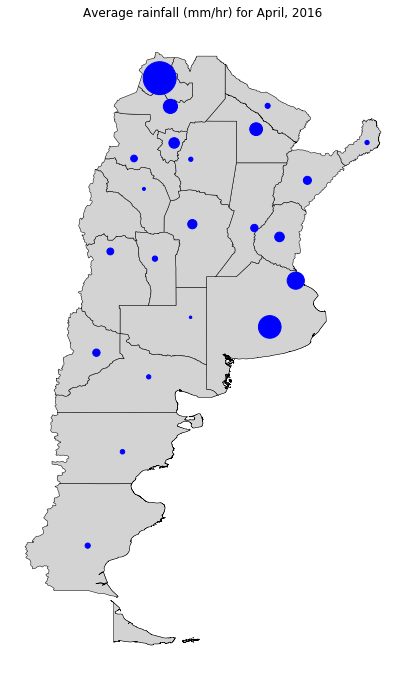

In [62]:
world = gpd.read_file("shapefiles/provinces/ARG_adm1.shp")

ax = world.plot(color = 'lightgrey', linewidth = 0.5, edgecolor = 'black', figsize = (20, 12))

points2 = [Point(xy) for xy in zip(zika_data_updated["longitude"], zika_data_updated["latitude"])]
zika_df = gpd.GeoDataFrame(zika_data_updated, crs = {'init': 'epsg:4326'}, geometry = points2)
zika_df.plot(column = 'value', ax = ax, markersize = 'value', color = 'blue')
plt.title("Average rainfall (mm/hr) for April, 2016")

ax.axis('off')

In [52]:
zika_data_updated[zika_data_updated["location"] == "San Juan"]

,location,latitude,longitude,value,geometry
17,San Juan,-31.533599,-68.502751,0,POINT (-68.50275 -31.53360)
